## Work
1. 試比較有 BN 在不同 Batch_size 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

In [1]:
!nvidia-smi

Sun Mar  6 17:28:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from tensorflow import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization, Activation

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], AB=True):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units)(input_layer)
            if AB:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
            else:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
        else:
            x = keras.layers.Dense(units=n_units)(x)
            if AB:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
            else:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                             

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [16, 64, 256, 1024]
MOMENTUM = 0.9

In [8]:
results_AB = {}
results_BA = {}

for bs in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉

    print(f"Experiment with BATCH_SIZE = {bs}, After Activation")
        
    model = build_mlp(input_shape=x_train.shape[1:], AB=True)

    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    history = model.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=bs, 
                        validation_data=(x_test, y_test), 
                        shuffle=True, 
                        verbose=0)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = (f"BATCH_SIZE: {bs}, After Activation")
    results_AB[exp_name_tag] = {'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc}
    
for bs in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉

    print(f"Experiment with BATCH_SIZE = {bs}, Before Activation")
        
    model = build_mlp(input_shape=x_train.shape[1:], AB=False)

    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    history = model.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        batch_size=bs, 
                        validation_data=(x_test, y_test), 
                        shuffle=True, 
                        verbose=0)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    exp_name_tag = (f"BATCH_SIZE: {bs}, Before Activation")
    results_BA[exp_name_tag] = {'train-loss': train_loss,
                                'valid-loss': valid_loss,
                                'train-acc': train_acc,
                                'valid-acc': valid_acc}

Experiment with BATCH_SIZE = 16, After Activation
Experiment with BATCH_SIZE = 64, After Activation
Experiment with BATCH_SIZE = 256, After Activation
Experiment with BATCH_SIZE = 1024, After Activation
Experiment with BATCH_SIZE = 16, Before Activation
Experiment with BATCH_SIZE = 64, Before Activation
Experiment with BATCH_SIZE = 256, Before Activation
Experiment with BATCH_SIZE = 1024, Before Activation


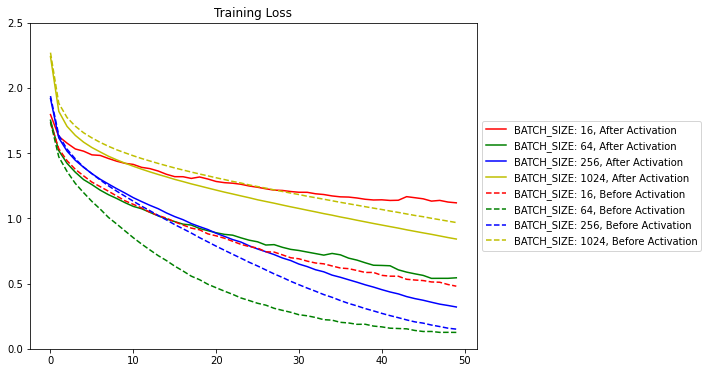

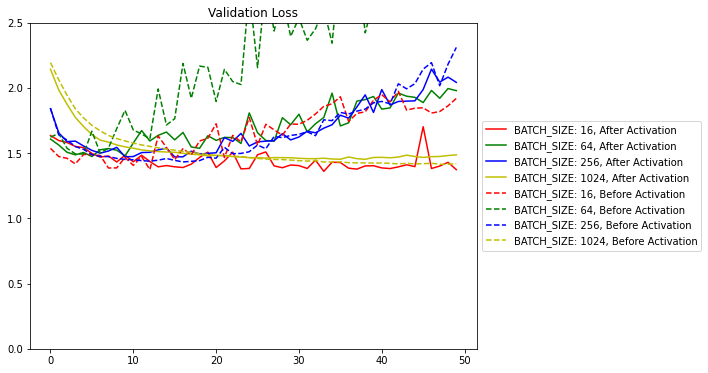

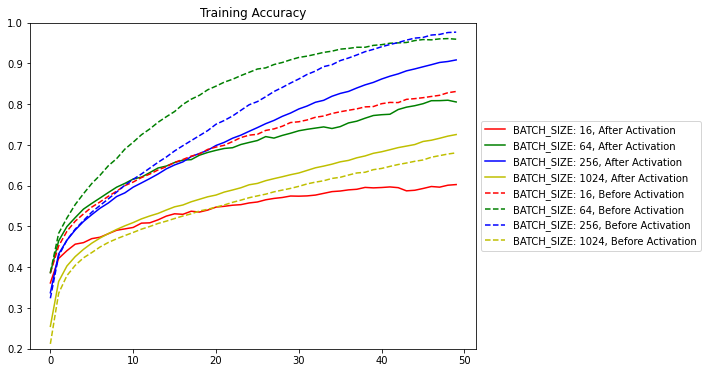

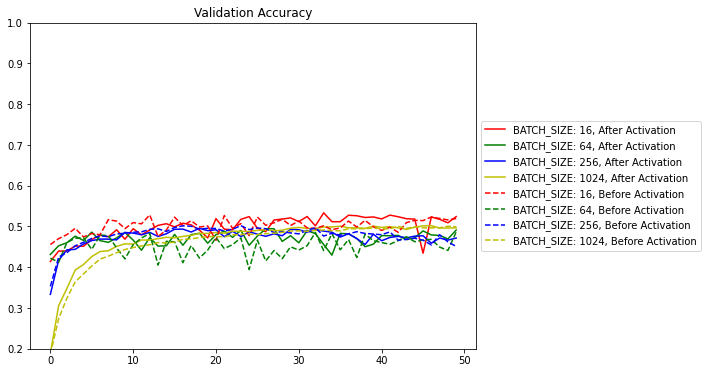

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results_AB.keys()):
    plt.plot(range(len(results_AB[cond]['train-loss'])), results_AB[cond]['train-loss'], 
             '-', label=cond, color=color_bar[i])
for i, cond in enumerate(results_BA.keys()):
    plt.plot(range(len(results_BA[cond]['train-loss'])), results_BA[cond]['train-loss'], 
             '--', label=cond, color=color_bar[i])
plt.title("Training Loss")
plt.ylim([0, 2.5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results_AB.keys()):
    plt.plot(range(len(results_AB[cond]['valid-loss'])), results_AB[cond]['valid-loss'], 
             '-', label=cond, color=color_bar[i])
for i, cond in enumerate(results_BA.keys()):
    plt.plot(range(len(results_BA[cond]['valid-loss'])), results_BA[cond]['valid-loss'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Loss")
plt.ylim([0, 2.5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results_AB.keys()):
    plt.plot(range(len(results_AB[cond]['train-acc'])), results_AB[cond]['train-acc'], 
             '-', label=cond, color=color_bar[i])
for i, cond in enumerate(results_BA.keys()):
    plt.plot(range(len(results_BA[cond]['train-acc'])), results_BA[cond]['train-acc'], 
             '--', label=cond, color=color_bar[i])
plt.title("Training Accuracy")
plt.ylim([0.2, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results_AB.keys()):
    plt.plot(range(len(results_AB[cond]['valid-acc'])), results_AB[cond]['valid-acc'], 
             '-', label=cond, color=color_bar[i])
for i, cond in enumerate(results_BA.keys()):
    plt.plot(range(len(results_BA[cond]['valid-acc'])), results_BA[cond]['valid-acc'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Accuracy")
plt.ylim([0.2, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()